In [1]:
import numpy as np 
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
#plt.style.use('seaborn-whitegrid')
plt.style.use('seaborn-colorblind')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'

import datetime
date = datetime.datetime.now().strftime('%Y%m%d')

%matplotlib inline

# Launch deployment

In [67]:
from dask.distributed import Client
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(
    project="aslee@10.110.16.5",
    queue='main',
    cores=25, 
    memory='10 GB',
    walltime="00:20:00",
    log_directory='job_logs'
)

In [66]:
client.close()
cluster.close()

In [76]:
client = Client(cluster)
#cluster.scale(200)
cluster.adapt(maximum=100)

In [70]:
client

Client Scheduler: tcp://10.110.16.11:33255 Dashboard: http://10.110.16.11:8787/status,Cluster Workers: 82 Cores: 410 Memory: 164.00 GB


# Read and normalize data
The spectra are normalized by the sum siginal in each row. For now, I don't think clr is needed yet.

In [2]:
merge_df = pd.read_csv('data/spe+bulk_dataset_20201008.csv', index_col = 0)
merge_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2043,2044,2045,2046,2047,TC%,TOC%,CaCO3%,core,mid_depth_mm
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.542079,0.394127,17.898887,SO264-64-1,115
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.247150,0.611208,13.632300,SO264-64-1,215
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.710588,0.523402,1.559822,SO264-64-1,305
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.562171,0.472551,0.746802,SO264-64-1,1015
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.578167,0.312852,2.210866,SO264-64-1,1815


In [3]:
X = merge_df.iloc[:, :-5].values
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [4]:
X = X / X.sum(axis = 1, keepdims = True)
X.shape

(382, 2048)

# Run PCA
To guess the possible components.

In [5]:
%%time
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pca = make_pipeline(StandardScaler(), PCA(n_components = 0.9))
pca.fit(X)

CPU times: user 1.6 s, sys: 37.8 ms, total: 1.64 s
Wall time: 390 ms


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=0.9))])

In [6]:
len(pca.named_steps['pca'].explained_variance_ratio_)

194

<BarContainer object of 194 artists>

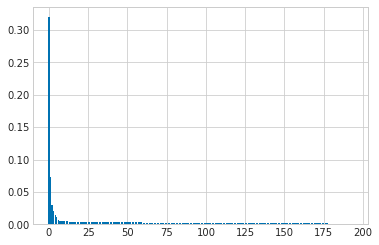

In [16]:
plt.bar(range(len(pca.named_steps['pca'].explained_variance_ratio_)), pca.named_steps['pca'].explained_variance_ratio_)

<BarContainer object of 30 artists>

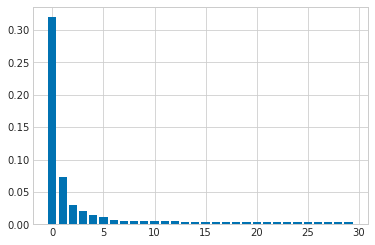

In [17]:
plt.bar(range(30), pca.named_steps['pca'].explained_variance_ratio_[:30])

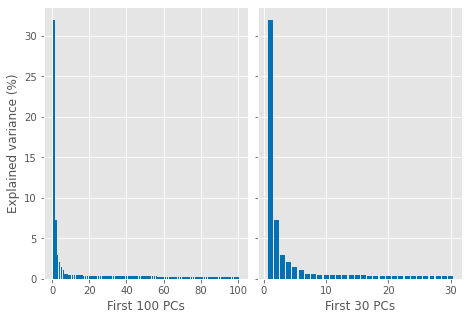

In [15]:
fug, ax = plt.subplots(1, 2, sharey = 'row', figsize = (7.5, 5))
ax[0].bar(range(1, 101), pca.named_steps['pca'].explained_variance_ratio_[:100]*100)
ax[1].bar(range(1, 31), pca.named_steps['pca'].explained_variance_ratio_[:30]*100)
ax[0].set_xlabel('First 100 PCs')
ax[1].set_xlabel('First 30 PCs')
ax[0].set_ylabel('Explained variance (%)')
plt.subplots_adjust(wspace = .05)
plt.savefig('results/pca_screeplot_{}.png'.format(date))

Potential component number would be 5.

# Build model for CaCO3

In [6]:
from dask_ml.model_selection import train_test_split
merge_df = dd.read_csv('data/spe+bulk_dataset_20201008.csv')
X = merge_df.iloc[:, 1: -5].to_dask_array(lengths=True)
X = X / X.sum(axis = 1, keepdims = True)
y = merge_df['CaCO3%'].to_dask_array(lengths=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True)

In [10]:
X_train

dask.array<from-value, shape=(305, 2048), dtype=float64, chunksize=(305, 2048), chunktype=numpy.ndarray>

In [7]:
X_test

dask.array<from-value, shape=(77, 2048), dtype=float64, chunksize=(77, 2048), chunktype=numpy.ndarray>

## A glance at the split

In [13]:
label = np.hstack((['train' for _ in range(len(y_train))], ['test' for _ in range(len(y_test))]))
ys = np.hstack((y_train, y_test))
ys_df = pd.DataFrame({'concentration': ys, 'dataset': label})

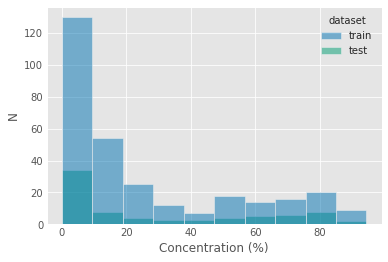

In [18]:
sns.histplot(x='concentration', data=ys_df, hue='dataset')
plt.xlabel('Concentration (%)')
plt.ylabel('N')
plt.savefig('results/train_test_distribution_{}.png'.format(date))

## Grid search 1
We know the relationship between the spectra and bulk measurements is not linear; and based on the pilot_test.ipynb, the SVR algorithm with NMF transformation provides the better cv score. So we focus on grid search with NMF transformation (4, 5, 6 and 7 components based on the PCA result) and SVR. 

In [71]:
%%time
from dask_ml.model_selection import GridSearchCV
from sklearn.decomposition import NMF
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(NMF(max_iter = 2000, random_state = 24), SVR())
params = {
    'nmf__n_components': [4, 5, 6, 7],
    'svr__C': np.logspace(0, 7, 8),
    'svr__gamma': np.logspace(-5, 0, 6)
}
grid = GridSearchCV(pipe, param_grid = params, cv = 10, n_jobs = -1)  

grid.fit(X_train, y_train)

print('The best cv score: {:.3f}'.format(grid.best_score_))
print('The best parameter: {}'.format(grid.best_params_))
print(grid.best_estimator_)

The best cv score: 0.967
The best parameter: {'nmf__n_components': 6, 'svr__C': 1000000.0, 'svr__gamma': 1.0}
Pipeline(steps=[('nmf', NMF(max_iter=2000, n_components=6, random_state=24)),
                ('svr', SVR(C=1000000.0, gamma=1.0))])
CPU times: user 12.6 s, sys: 561 ms, total: 13.2 s
Wall time: 18.6 s


In [72]:
grid.best_estimator_.score(X_test, y_test)

0.9794485935468025

In [7]:
# this is an older version using only 10-fold cv and 200 max_iter in NMF
%%time
from dask_ml.model_selection import GridSearchCV
from sklearn.decomposition import NMF
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(NMF(random_state = 24), SVR())
params = {
    'nmf__n_components': [4, 5, 6, 7],
    'svr__C': np.logspace(0, 7, 8),
    'svr__gamma': np.logspace(-5, 0, 6)
}
grid = GridSearchCV(pipe, param_grid = params, cv = 5, n_jobs = -1)  

grid.fit(X_train, y_train)

print('The best cv score: {:.3f}'.format(grid.best_score_))
print('The best parameter: {}'.format(grid.best_params_))
print(grid.best_estimator_)

The best cv score: 0.974
The best parameter: {'nmf__n_components': 6, 'svr__C': 1000000.0, 'svr__gamma': 1.0}
Pipeline(steps=[('nmf', NMF(n_components=6, random_state=24)),
                ('svr', SVR(C=1000000.0, gamma=1.0))])
CPU times: user 4.86 s, sys: 265 ms, total: 5.12 s
Wall time: 13.6 s


In [8]:
grid.best_estimator_.score(X_test, y_test)

0.9635143728795432

In [73]:
result_df = pd.DataFrame(grid.cv_results_)
result_df.to_csv('results/gridsearch_nmf+svr_{}.csv'.format(date))
#result_df = pd.read_csv('results/gridsearch_nmf+svr_20201009.csv', index_col = 0)
#result_df = result_df[result_df.mean_test_score > -1].reset_index(drop = True)

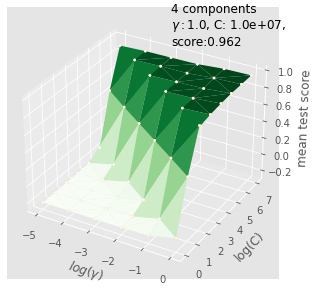

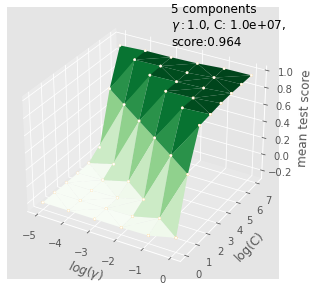

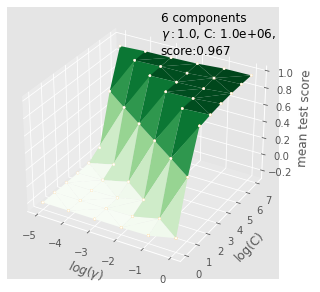

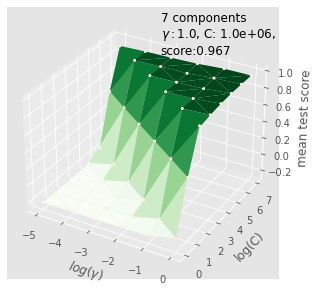

In [74]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

for n_components in [4, 5, 6, 7]:
    data = result_df[result_df.param_nmf__n_components == n_components].reset_index(drop = True)
    fig = plt.figure(figsize = (7.3,5))
    ax = fig.gca(projection='3d')
    xx = data.param_svr__gamma.astype(float)
    yy = data.param_svr__C.astype(float)
    zz = data.mean_test_score.astype(float)
    max_index = np.argmax(zz)

    surf = ax.plot_trisurf(np.log10(xx), np.log10(yy), zz, cmap=cm.Greens, linewidth=0.1)
    ax.scatter3D(np.log10(xx), np.log10(yy), zz, c = 'orange', s = 5)
    # mark the best score
    ax.scatter3D(np.log10(xx), np.log10(yy), zz, c = 'w', s = 5, alpha = 1)
    text = '{} components\n$\gamma :{:.1f}$, C: {:.1e},\nscore:{:.3f}'.format(n_components, xx[max_index], yy[max_index], zz[max_index])
    ax.text(np.log10(xx[max_index])-3, np.log10(yy[max_index]), 
            zz[max_index]+.1,text,
            fontsize=12)

    ax.set_xlabel('$log(\gamma)$')
    ax.set_ylabel('log(C)')
    ax.set_zlabel('mean test score')
    #fig.colorbar(surf, shrink=0.5, aspect=5)
    fig.savefig('results/grid_caco3_{}nmr+svr_3D_{}.png'.format(n_components, date))

The dask sesssion fails when I try gamma larger than 1. Although the topography of the scores encourage me to find the down-slope at larger gamma, it is not practicle to try that big value of gamma because gamma is a invert number of the distance for the kernel (radical function) computation. The distance can't be too small otherwise there is no neighboring data points included and raises error in SVR, which makes the worker failed. Also, the test score (0.96, not the cv score) is good enough. Therefore, in this combination, I would choose 6 component NMF and SVR (${\gamma}$: 1, C: 1e+6) as the best model.

## Grid search 2
Due to curiosity, let's try the SVR algorithm with PCA transformation.

In [63]:
%%time
from dask_ml.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(StandardScaler(), PCA(n_components = 5, whiten = True), SVR())
params = {
    'svr__C': np.logspace(0, 7, 8),
    'svr__gamma': np.logspace(-8, -1, 8)
}
grid = GridSearchCV(pipe, param_grid = params, cv = 5, n_jobs = -1)

grid.fit(X_train, y_train)

print('The best cv score: {:.2f}'.format(grid.best_score_))
print('The best parameter: {}'.format(grid.best_params_))
print(grid.best_estimator_)

The best cv score: 0.97
The best parameter: {'svr__C': 100000.0, 'svr__gamma': 0.01}
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=5, whiten=True)),
                ('svr', SVR(C=100000.0, gamma=0.01))])
CPU times: user 2min 1s, sys: 6.02 s, total: 2min 7s
Wall time: 7min 13s


In [64]:
grid.best_estimator_.score(X_test, y_test)

/home/users/aslee/miniconda3/lib/python3.7/site-packages/dask/array/core.py:1359: FutureWarning: The `numpy.may_share_memory` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  FutureWarning,


0.9430163497379823

In [65]:
result_df = pd.DataFrame(grid.cv_results_)
result_df.to_csv('results/gridsearch_pca+svr_{}.csv'.format(date))
#result_df = result_df[result_df.mean_test_score > -1].reset_index(drop = True)

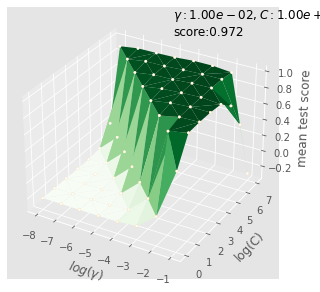

In [69]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure(figsize = (7,5))
ax = fig.gca(projection='3d')
xx = result_df.param_svr__gamma.astype(float)
yy = result_df.param_svr__C.astype(float)
zz = result_df.mean_test_score.astype(float)
max_index = np.argmax(zz)

surf = ax.plot_trisurf(np.log10(xx), np.log10(yy), zz, cmap=cm.Greens, linewidth=0.1)
ax.scatter3D(np.log10(xx), np.log10(yy), zz, c = 'orange', s = 5)
# mark the best score
ax.scatter3D(np.log10(xx), np.log10(yy), zz, c = 'w', s = 5, alpha = 1)
text = '$\gamma :{:.2e}, C:{:.2e}$,\nscore:{:.3f}'.format(xx[max_index], yy[max_index], zz[max_index])
ax.text(np.log10(xx[max_index])-2, np.log10(yy[max_index]), 
        zz[max_index]+.5,text,
        fontsize=12)

ax.set_xlabel('$log(\gamma)$')
ax.set_ylabel('log(C)')
ax.set_zlabel('mean test score')
#fig.colorbar(surf, shrink=0.5, aspect=5)
fig.savefig('results/grid_caco3_pca+svr_3D_{}.png'.format(date))

Both the cv score and test score are alightly lower than the combination of NMF+SVR.

# What? Ridge can have both scores 0.94?
It's so weird... First, linear algorithm shouldnt' be this good. Second, if we don't separate data into training and test sets, the score drops to 0.63. It might be data snooping issue?

## Use split datasets

In [89]:
%%time
from dask_ml.model_selection import GridSearchCV
from sklearn.decomposition import NMF
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline

ridge = make_pipeline(NMF(random_state = 24), Ridge())
params = {
    'nmf__n_components': [4, 5, 6, 7],
    'ridge__alpha': np.logspace(-3, 0, 20)}
grid = GridSearchCV(ridge, param_grid = params, cv = 5, n_jobs = -1)

grid.fit(X_train, y_train)

print('The best cv score: {:.3f}'.format(grid.best_score_))
print('The best parameter: {}'.format(grid.best_params_))
print(grid.best_estimator_)

The best cv score: 0.939
The best parameter: {'nmf__n_components': 5, 'ridge__alpha': 0.001}
Pipeline(steps=[('nmf', NMF(n_components=5, random_state=24)),
                ('ridge', Ridge(alpha=0.001))])
CPU times: user 4.05 s, sys: 270 ms, total: 4.32 s
Wall time: 7.19 s


In [90]:
grid.best_estimator_.score(X_test, y_test)

0.9417329736391749

In [91]:
result_df = pd.DataFrame(grid.cv_results_)

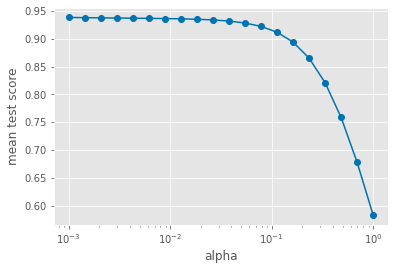

In [93]:
data = result_df[result_df.param_nmf__n_components == 5]
plt.plot(data['param_ridge__alpha'], data['mean_test_score'], marker = 'o')
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('mean test score')
fig.savefig('results/grid_caco3_pca+ridge_{}.png'.format(date))

Text(0, 0.5, 'mean test score')

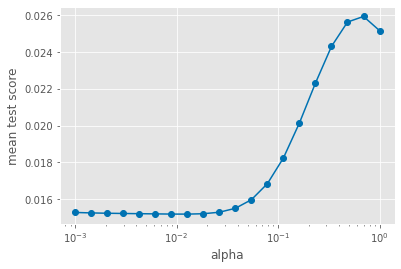

In [94]:
data = result_df[result_df.param_nmf__n_components == 5]
plt.plot(data['param_ridge__alpha'], data['std_test_score'], marker = 'o')
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('mean test score')
#fig.savefig('grid_caco3_pca+ridge_{}.png'.format(date))

## Use the whole dataset

In [7]:
%%time
from dask_ml.model_selection import GridSearchCV
from sklearn.decomposition import NMF
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline

ridge = make_pipeline(NMF(n_components = 5, random_state = 24), Ridge())
params = {'ridge__alpha': np.logspace(-3, 0, 20)}
grid = GridSearchCV(ridge, param_grid = params, cv = 5, n_jobs = -1)

grid.fit(X, y)

print('The best cv score: {:.3f}'.format(grid.best_score_))
print('The best parameter: {}'.format(grid.best_params_))
print(grid.best_estimator_)

The best cv score: 0.646
The best parameter: {'ridge__alpha': 0.008858667904100823}
Pipeline(steps=[('nmf', NMF(n_components=5, random_state=24)),
                ('ridge', Ridge(alpha=0.008858667904100823))])
CPU times: user 698 ms, sys: 32.8 ms, total: 731 ms
Wall time: 5.24 s


Text(0, 0.5, 'mean test score')

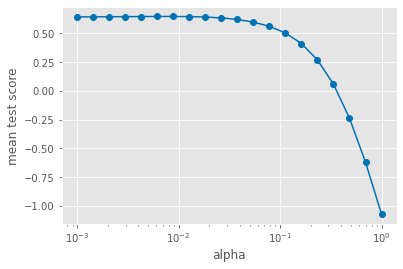

In [8]:
plt.plot(params['ridge__alpha'], grid.cv_results_['mean_test_score'], marker = 'o')
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('mean test score')
#fig.savefig('caco3_pca+ridge_grid_scores.png')

## Build the best model
Actualy the grid search has done this, but I didn't export the weights (i.e. model), so I need to do it again.

In [75]:
%%time
from sklearn.decomposition import NMF
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(NMF(max_iter = 2000, n_components = 6, random_state = 24), SVR(C = 1e+6, gamma = 1))
pipe.fit(X_train, y_train)

print('The test score: {:.3f}'.format(pipe.score(X_test, y_test)))

The test score: 0.979
CPU times: user 9.37 s, sys: 6.88 s, total: 16.2 s
Wall time: 2.72 s


In [77]:
from joblib import dump, load
#model = load(models/ssss.joblib)
dump(pipe, 'models/caco3_nmf+svr_model_{}.joblib'.format(date)) 

['models/caco3_nmf+svr_model_20201011.joblib']